# PASSION Dataset Loader

In [1]:
!pip install -r ../requirements.txt -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
clean-py 0.5 requires black==22.3.0, but you have black 24.2.0 which is incompatible.
clean-py 0.5 requires isort==4.3.21, but you have isort 5.13.2 which is incompatible.
label-studio 1.7.1 requires boto3~=1.16.28, but you have boto3 1.33.1 which is incompatible.
label-studio 1.7.1 requires botocore~=1.19.28, but you have botocore 1.33.1 which is incompatible.
label-studio 1.7.1 requires jsonschema==3.2.0, but you have jsonschema 4.19.2 which is incompatible.
label-studio 1.7.1 requires pydantic<=1.8.2,>=1.7.3, but you have pydantic 2.5.2 which is incompatible.
label-studio 1.7.1 requires python-dateutil==2.8.1, but you have python-dateutil 2.8.2 which is incompatible.
label-studio 1.7.1 requires pytz~=2019.3, but you have pytz 2024.1 which is incompatible.
pytest-memray 1.3.0 requires pytest>=7.1.2, but you have

In [2]:
import re
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import sys
sys.path.append("../")

from ssl_library.src.datasets.downstream_tasks.passion_dataset import PASSIONLabel
from ssl_library.src.datasets.helper import DatasetName, get_dataset

In [3]:
save_fig_path = Path("../assets/notebook_outputs/")
dataset_name = DatasetName.PASSION

In [4]:
!ls ../data/PASSION

data  diverse  PASSION_collection_2020_2023


In [50]:
dataset, torch_dataset = get_dataset(
    dataset_name=dataset_name,
    dataset_path=Path("../data/PASSION/PASSION_collection_2020_2023"),
    split_file='PASSION_split.csv',
    batch_size=16,
    #label_col=PASSIONLabel.IMPETIGO,
    return_fitzpatrick=False,
    image_extensions=("*.jpeg", "*.jpg", "*.JPG", "*.JPEG", "*.PNG", "*.png"),
)

len(dataset)

Loaded `passion` which contains 266 batches with a batch size of 16.


4243

In [51]:
dataset.classes

['Others', 'Atopic Dermatitis', 'Dermatophytosis', 'Scabies']

In [52]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=4032x3024>,
 '../data/PASSION/PASSION_collection_2020_2023/Subject Files/2022/Files_Matrix_AA00971399/Passion CRF/imageupload_(crf)_5.jpg',
 0)

In [6]:
dataset.meta_data.head()

,img_path,img_name,subject_id,Split,country,Subject,age,sex,fitzpatrick,body_loc,impetig,diagnosis,icd10,icd11,conditions_PASSION,lbl_conditions_PASSION
0,../data/PASSION/PASSION_collection_2020_2023/S...,imageupload_(crf)_2,AA00971820,TRAIN,Madagascar,AA00971820-R P,49,f,5,"arm, back, hand, butt",0.0,Scabies,B86,1G04,Scabies,0
1,../data/PASSION/PASSION_collection_2020_2023/S...,imageupload_(crf)_4,AA00970301,TEST,Guinea,AA00970301-M T,11,m,3,hair,0.0,Tinea Capitis,B35.0,1F28.0,Dermatophytosis,1
2,../data/PASSION/PASSION_collection_2020_2023/S...,imageupload_(crf)_13,AA00971619,TRAIN,Tanzania,AA00971619-N B,3,m,3,"back, hand, torso, arm, leg, butt",0.0,Scabies,B86,1G04,Scabies,0
3,../data/PASSION/PASSION_collection_2020_2023/S...,1C1C4004-FB05-4208-A67B-B9F2C7AA4849_1,AA00970197,TEST,Madagascar,AA00970197-R H,56,f,4,NaN,1.0,Atopic Dermatitis Impetigenized,L20.82,EA80.2,Atopic Dermatitis,2
4,../data/PASSION/PASSION_collection_2020_2023/S...,imageupload_(crf)_3,AA00970209,TRAIN,Guinea,AA00970209-M C,21,f,6,arm,0.0,Atopic Dermatitis,L20,EA80,Atopic Dermatitis,2


## Train Splitting

Splitting based on: classes, subject_id, country

In [9]:
_df = dataset.meta_data.groupby('subject_id').agg(list)
for _c in ['conditions_PASSION', 'country', 'sex', 'age', 'fitzpatrick', 'body_loc']:
    display(_df[_c].apply(lambda x: len(set(x))).value_counts())

conditions_PASSION
1    1341
Name: count, dtype: int64

country
1    1341
Name: count, dtype: int64

sex
1    1341
Name: count, dtype: int64

age
1    1341
Name: count, dtype: int64

fitzpatrick
1    1341
Name: count, dtype: int64

body_loc
1    1341
Name: count, dtype: int64

In [43]:
df_splitting = dataset.meta_data.drop_duplicates(subset=['subject_id'])
stratified_label = df_splitting['conditions_PASSION'].astype(str) + df_splitting['country'].astype(str)
subjects_train, subjects_test = train_test_split(df_splitting['subject_id'].values, stratify=stratified_label, train_size=0.80, random_state=42)

In [44]:
subjects_train.shape, subjects_test.shape

((1072,), (269,))

In [56]:
df_train = dataset.meta_data[dataset.meta_data['subject_id'].isin(subjects_train)]
df_test = dataset.meta_data[dataset.meta_data['subject_id'].isin(subjects_test)]

In [58]:
_sel_train = dataset.meta_data['subject_id'].isin(subjects_train)
_sel_test = dataset.meta_data['subject_id'].isin(subjects_test)
dataset.meta_data.loc[_sel_train, 'Split'] = 'TRAIN'
dataset.meta_data.loc[_sel_test, 'Split'] = 'TEST'

In [59]:
dataset.meta_data['Split'].value_counts()

Split
TRAIN    3387
TEST      856
Name: count, dtype: int64

In [52]:
set.intersection(set(df_train['subject_id'].unique()), set(df_test['subject_id'].unique()))

set()

In [73]:
df_subjects_train = pd.DataFrame(subjects_train, columns=['subject_id'])
df_subjects_train['Split'] = 'TRAIN'

df_subjects_test = pd.DataFrame(subjects_test, columns=['subject_id'])
df_subjects_test['Split'] = 'TEST'

pd.concat([df_subjects_train, df_subjects_test]).to_csv('../data/PASSION/PASSION_collection_2020_2023/PASSION_split.csv', index=False)

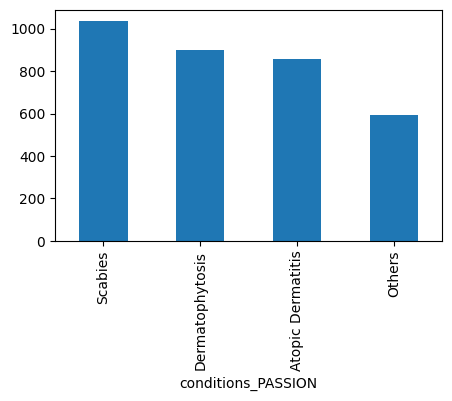

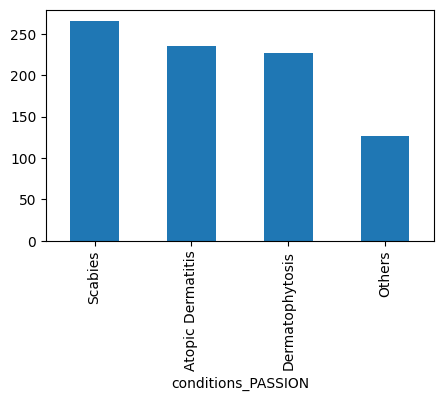

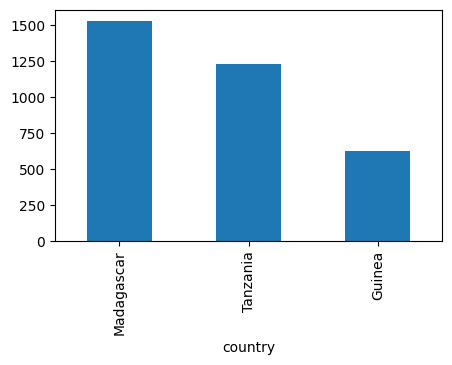

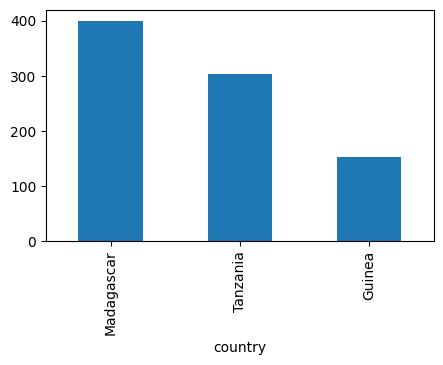

In [55]:
for _c in ['conditions_PASSION', 'country']:
    for _df in [df_train, df_test]:
        _df[_c].value_counts().plot(kind='bar', figsize=(5,3))
        plt.show()